In [65]:
import pandas as pd
import numpy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter 
import re
import plotly.express as px

In [2]:
# Data overview and preprocessing

In [3]:
tweet=pd.read_csv('tweet_emotions.csv')

In [4]:
sentiment=pd.DataFrame(tweet.sentiment.value_counts())

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

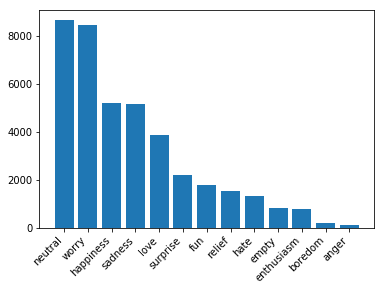

In [5]:
plt.bar(x=sentiment.index, height=sentiment['sentiment'])
plt.xticks(rotation=45,ha='right')

In [6]:
contents=list(tweet.content)

In [7]:
contents[0]

'@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =['

In [8]:
contents_clean=[]
for sentence in contents:
    # get rid of @xxx
    sentence2=" ".join([x for x in sentence.split(" ") if not x.startswith("@")])
    contents_clean.append(sentence2)

In [9]:
stop_words=set(stopwords.words('english'))

In [10]:
contents_nostopwords=[]
for sentence in contents_clean:
    words=word_tokenize(sentence)
    words=[x for x in words if x not in stop_words]
    contents_nostopwords.append(" ".join(words))

In [11]:
len(contents_nostopwords[0].split(" "))

10

In [12]:
sentence_length=[len(x.split(' ')) for x in contents_nostopwords]

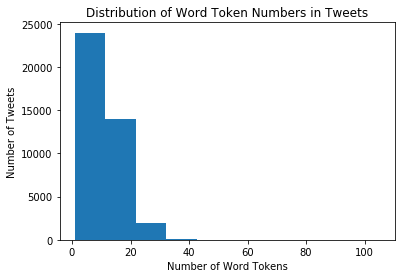

In [13]:
plt.hist(sentence_length)
plt.xlabel("Number of Word Tokens")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Word Token Numbers in Tweets")
plt.show()

In [14]:
max(sentence_length)

105

In [58]:
# remove punctuation
contents_nostopwords=[re.sub(r'[^\w\s]','',sentence) for sentence in contents_nostopwords]

In [67]:
# Study the common words in top 8 sentiments, worry, happiness, sadness, love, surprise, fun, relief, hate

In [71]:
chosen_sentiments=list(sentiment[1:9].index)

In [72]:
chosen_sentiments

['worry', 'happiness', 'sadness', 'love', 'surprise', 'fun', 'relief', 'hate']

In [91]:
for s in chosen_sentiments:
    chosen_index=list(tweet[tweet.sentiment==s].index)
    chosen_contents=[contents_nostopwords[i].lower() for i in chosen_index]
    print('There are %i %s sentiments in trainning set.'%(len(chosen_contents), s))
    templist = [x.split(' ') for x in chosen_contents]
    top = Counter([item for sublist in templist for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words in %s sentences'%s)
    fig.show()

There are 8459 worry sentiments in trainning set.


There are 5209 happiness sentiments in trainning set.


There are 5165 sadness sentiments in trainning set.


There are 3842 love sentiments in trainning set.


There are 2187 surprise sentiments in trainning set.


There are 1776 fun sentiments in trainning set.


There are 1526 relief sentiments in trainning set.


There are 1323 hate sentiments in trainning set.


In [15]:
# Prepare training and testing set for training

In [92]:
import warnings
warnings.simplefilter("ignore")
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

In [93]:
X_train, X_test, y_train, y_test = train_test_split(contents_nostopwords, list(tweet.sentiment), test_size=0.2, random_state=42)

In [94]:
num_words=10000
maxlen=50

In [95]:
tokenizer=Tokenizer(
    num_words=num_words-1,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    oov_token = '<UNK>'
)

In [96]:
tokenizer.fit_on_texts(
    X_train
)

In [21]:
word_index=tokenizer.word_index

In [22]:
len(word_index)

28349

In [97]:
train_sequences=tokenizer.texts_to_sequences(X_train)
train_padded=pad_sequences(train_sequences,padding='post',maxlen = maxlen, truncating='post')

In [104]:
test_sequences=tokenizer.texts_to_sequences(X_test)
test_padded=pad_sequences(test_sequences,padding='post', maxlen=maxlen, truncating='post')

In [105]:
train_padded.max().max()

9998

In [106]:
import numpy as np
training_padded = np.array(train_padded)
testing_padded = np.array(test_padded)
for a in testing_padded:
    np.place(a, a>9998, 9999)   # change the token of out of vocabulory word from the max 28349 in our datasets to 9999 

In [107]:
# One hot encode y lables to binary vectors
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)
ohe = OneHotEncoder()
ohe.fit(y_train)
y_train_enc = ohe.transform(y_train)
y_test_enc = ohe.transform(y_test)

In [28]:
y_train_enc

<32000x13 sparse matrix of type '<class 'numpy.float64'>'
	with 32000 stored elements in Compressed Sparse Row format>

In [108]:
# Build and train models

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

In [110]:
model=Sequential()
# embeding layer to tansfer each integer word token to vector of length 100
model.add(Embedding(input_dim=num_words, output_dim=50, input_length=50)) 
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(Dense(30, activation='relu'))
model.add(Dense(13, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [111]:
history = model.fit(train_padded, y_train_enc, validation_data=(testing_padded, y_test_enc), epochs=50, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/50
32000/32000 [==============================] - 10s 316us/step - loss: 2.0361 - acc: 0.2922 - val_loss: 1.9627 - val_acc: 0.3294
Epoch 2/50
32000/32000 [==============================] - 10s 298us/step - loss: 1.8250 - acc: 0.3819 - val_loss: 1.9578 - val_acc: 0.3342
Epoch 3/50
32000/32000 [==============================] - 10s 305us/step - loss: 1.6631 - acc: 0.4400 - val_loss: 1.9707 - val_acc: 0.3406
Epoch 4/50
32000/32000 [==============================] - 10s 306us/step - loss: 1.5016 - acc: 0.4939 - val_loss: 2.1536 - val_acc: 0.3351
Epoch 5/50
32000/32000 [==============================] - 10s 303us/step - loss: 1.3611 - acc: 0.5412 - val_loss: 2.2496 - val_acc: 0.3015
Epoch 6/50
32000/32000 [==============================] - 10s 303us/step - loss: 1.2453 - acc: 0.5780 - val_loss: 2.5124 - val_acc: 0.3069
Epoch 7/50
32000/32000 [==============================] - 10s 326us/step - loss: 1.1452 - acc: 0.6128 - val_loss: 2.6

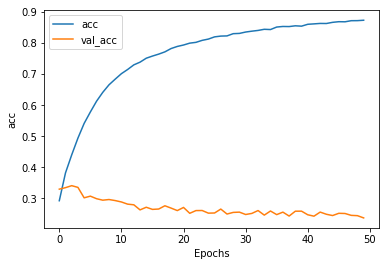

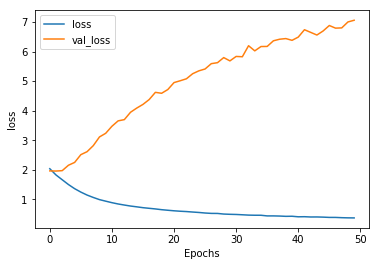

In [112]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
# According to the plots, we can see the accuracy on validation set is low and overfitting is a problem. 